<a name='1'></a>
## Importing all Necessary Packages

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy

np.random.seed(1)

In [2]:
# defining sigmoid, sigmoid_backward, ReLU, ReLU_backward
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ


# Initialize Parameters

In [3]:
# Initialize for 2-layer Neural Network
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters  


In [4]:
# Initialize Parameters for l-layer Neural Network
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

# Forward Propagation Module

In [5]:

def linear_forward(A, W, b):
    
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

# Linear-Activation Forward

In [6]:

def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

# L Model Forward

In [7]:

def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "sigmoid")
    caches.append(cache)
    
          
    return AL, caches

# Cost Function

In [8]:

def compute_cost(AL, Y):
    
    m = Y.shape[1]

    cost = -(np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))) / m
    cost = np.squeeze(cost)   
    return cost

# Backward Propagation Module

In [9]:

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis = 1, keepdims = True) / m
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

# Linear-Activation Backward

In [10]:

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

# L-Model Backward

In [11]:

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

# Update Parameters

In [12]:

def update_parameters(params, grads, learning_rate):
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

# Importing Libraries

In [13]:
import time
import scipy
from PIL import Image
from scipy import ndimage

np.random.seed(1)

# Load and Process the data

In [14]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")

    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # train images
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # train labels

    test_set_x_orig = np.array(test_dataset["test_set_x"][:])     # test images
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])     # test labels

    classes = np.array(test_dataset["list_classes"][:])           # list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [15]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

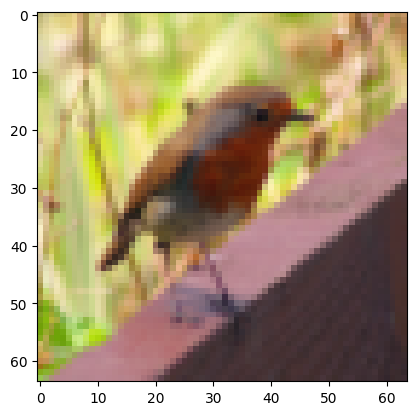

y = 0. It's a non-cat picture.


In [16]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
plt.show()

print("y = " + str(train_y[0, index]) + ". It's a " + classes[train_y[0, index]].decode("utf-8") + " picture.")


In [17]:
# Explore dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [18]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


# 2-Layer Neural Network

In [19]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [20]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)

    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = "sigmoid")
    
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = "relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations and for the last iteration
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
            
    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Cost after iteration 0: 0.6930497356599891
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366414
Cost after iteration 1100: 0.30527536361962654
Cost after iteration 1200: 0.27491377282130147
Cost after iteration 1300: 0.24681768210614854
Cost after iteration 1400: 0.19850735037466102
Cost after iteration 1500: 0.1744831811255665
Cost after iteration 1600: 0.1708076297809649
Cost after iteration 1700: 0.1130652456216472
Cost after iteration 1800: 0.09629426845937152
Cost after iteration 1900: 0.08342617959726865
Cost after iteration 2000: 0.07439078704319083
Cost after iteration 2100: 0.0663074813

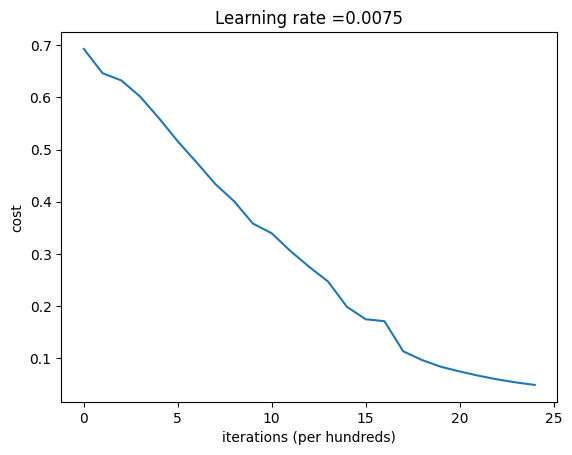

In [21]:
# training the model
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

In [22]:
# defining predict function
def predict(X, y, parameters):
    m = X.shape[1]
    probas, caches = L_model_forward(X, parameters)
    p = (probas > 0.5).astype(int)
    accuracy = np.mean(p == y)
    return accuracy


In [23]:
# predicting training accuracy
pred_train = predict(train_x, train_y, parameters)
print(pred_train)

1.0


In [24]:
# predicting test accuracy
pred_test = predict(test_x, test_y, parameters)
pred_test

0.72

# L-Layer Neural Network

In [25]:
# CONSTANTS
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [26]:
# Defining Neural Network for L layers
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    
    np.random.seed(1)
    costs = []                        
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Printing the cost for every 100 iterations and for the last iteration
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
    
    return parameters, costs

In [27]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.715731513413713
Cost after iteration 100: 0.6747377593469114
Cost after iteration 200: 0.6603365433622127
Cost after iteration 300: 0.6462887802148751
Cost after iteration 400: 0.6298131216927773
Cost after iteration 500: 0.606005622926534
Cost after iteration 600: 0.5690041263975134
Cost after iteration 700: 0.519796535043806
Cost after iteration 800: 0.46415716786282285
Cost after iteration 900: 0.40842030048298916
Cost after iteration 1000: 0.37315499216069026
Cost after iteration 1100: 0.30572374573047106
Cost after iteration 1200: 0.26810152847740837
Cost after iteration 1300: 0.23872474827672654
Cost after iteration 1400: 0.20632263257914718
Cost after iteration 1500: 0.17943886927493605
Cost after iteration 1600: 0.1579873581880163
Cost after iteration 1700: 0.14240413012274492
Cost after iteration 1800: 0.12865165997888675
Cost after iteration 1900: 0.1124431499816437
Cost after iteration 2000: 0.08505631034982422
Cost after iteration 2100: 0.057583911

In [28]:
pred_train = predict(train_x, train_y, parameters)
print(pred_train)

0.9952153110047847


In [29]:
pred_test = predict(test_x, test_y, parameters)
print(pred_test)

0.78


# Predictions

y = 1.0, It is  a "cat" picture.


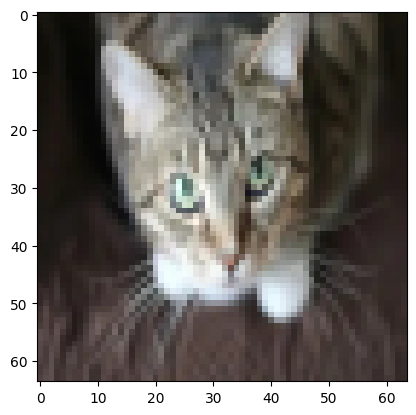

In [30]:
my_image = "my_image1.jpg" # changing this to the name of image file 
my_label_y = [1] # the true class of image (1 -> cat, 0 -> non-cat)


fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", It is  a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")
plt.show()

In [31]:
# define function for predicting image as cat or non_cat
def predict_image(image_name):
    my_image = image_name # changing this to the name of your image file 
    my_label_y = [1] # the true class of image (1 -> cat, 0 -> non-cat)


    fname = "images/" + my_image
    image = np.array(Image.open(fname).resize((num_px, num_px)))
    plt.imshow(image)

    image = image / 255.
    image = image.reshape((1, num_px * num_px * 3)).T

    my_predicted_image = predict(image, my_label_y, parameters)


    print ("y = " + str(np.squeeze(my_predicted_image)) + ", It is a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")
    plt.show()

y = 0.0, It is a "non-cat" picture.


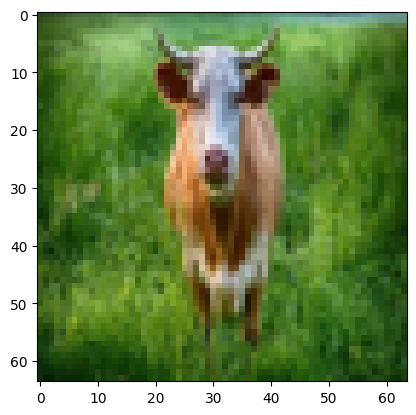

In [32]:
image = predict_image("OIP-_6_.jpg")

y = 0.0, It is a "non-cat" picture.


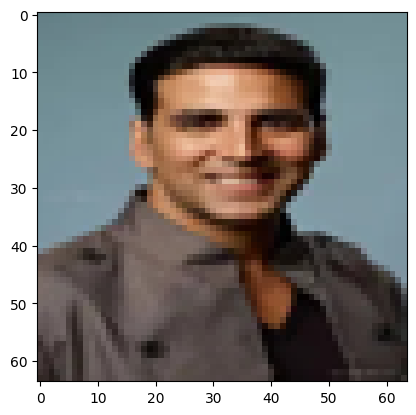

In [33]:
image = predict_image("OIP-_7_.jpg")

y = 1.0, It is a "cat" picture.


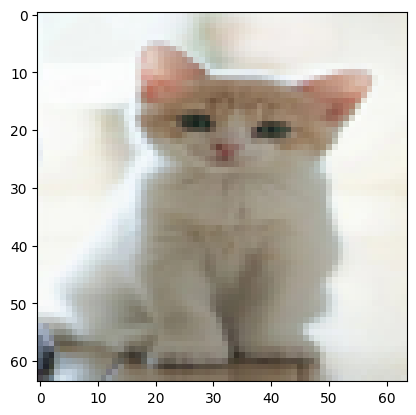

In [34]:
image = predict_image("OIP-_8_.jpg")

y = 1.0, It is a "cat" picture.


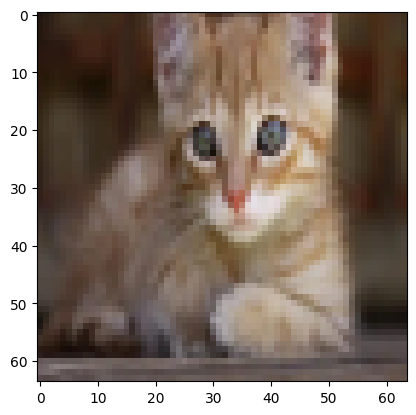

In [35]:
image = predict_image("OIP-_9_.jpg")